In [1]:
## Setting up environments
import os
import json
import numpy as np
import pandas as pds
from copy import deepcopy
from random import shuffle, randint, uniform

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

**Note**: networkx, scipy, and scikit-learn packages are needed in this demonstration

In [2]:
import sys
sys.path.insert(0, './')
from Pareto import *
from basics import *
from network_mvc import *

matplotlib.rcParams['font.family'] = "Sans-serif"
matplotlib.rcParams['font.serif'] = "Arial" # Helvetica
matplotlib.rcParams['font.style'] = "normal"
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['mathtext.fontset'] = "custom"
matplotlib.rcParams['mathtext.rm'] = "Arial"

In [3]:
## To construct graphs
import networkx as nx
## To calculate correlations
from scipy.stats import pearsonr

# 1. Correlation graphs and identify representative properties
&emsp; Here we first construct the correlation graphs of property errors (the normalized error metrics) and then identify the representative properties.  

 - **Why correlation graphs?**  
   &emsp; Correlations of the error metrics for properties are critical to develop MLIP models which can reproduce accurate physical phenomenon. In general, correlated properties may not necessarily lead to correlated errors, and vice versa, e.g., two independent sensors in the same wind tunnel often have correlated readouts but their errors are not correlated. The correlations of error metrics of properties here may be caused by both the connections of physical procedures (like the heat conduction, the diffusion, and the atom vibration), and the choices of MLIP models, descriptors, or even training data. Therefore, to reproduce accurate physical phenomenon, learning and comparing the correlations of error metrics of properties for different MLIPs will be important.  
   &emsp; The correlations of error metrics in the graphs are calculated using Pearson's correlation coefficient *r* in scipy package. We choose a threshold $r^{\mathrm{2}}$ > 0.6, which is typically interpreted as strong correlations and corresponds to $|r|$ slightly lower than 0.8, and use these high correlations to construct the graphs. The produced figure here follows the scheme in *Figure 7* and *Supplementary Figure S8*.  
   
 - **Why to select representative properties?**  
   &emsp; If a group of properties are strongly correlated with each other, there only needs a few of those properties to represent the whole group. This largely reduces the burden of analyses and simplifies the understanding and the strategy to train better MLIPs. Computationally, it can be beneficial especially if the simulation-based properties (which require running many simulations by the finalized models) can be represented by other simple properties that are cheap to compute. Further, using representative properties and reducing the property number can prevent 'property inflation', which duplicates several correlated property errors of similar performances and can be misleading for interpretation.
   
 - **How to select representative properties?**  
   &emsp; Here we use a customized recursive function $simplePageRankMVC$ in `network_mvc.py` to select representative properties. This function basically mimics the process of [minimum vertex cover (MVC)](https://en.wikipedia.org/wiki/Vertex_cover) in graph algorithm, but it selects the representative properties (the nodes in correlation graphs) if they connect with, or cover, all nodes. Detailed steps of the function are provided in the methods section in the main text. However, it's worthwhile to **emphasize** that this function differs from typical MVC since it neglects the need of covering all edges and <u>it should not be considered as an MVC algorithm</u>.

In [4]:
"""
    Load necessary information 1
"""
## Get the color for each type of MLIP
modelcolor = {}
for m, n in zip(model_label_csv['Models'], model_label_csv['Color']):
    modelcolor[m] = n

## Get the color for each category of properties
propertycolor = {}
for m, n in zip(category_label_csv['Categories'], category_label_csv['color']):
    propertycolor[m] = n

## We need normalized log errors to calculate correlations
norm_log_data = pds.read_csv('data/normalized_log_errors.csv').drop(columns=['Unnamed: 0'])
norm_log_data.head()

,Models,ModelName,SelectionType,TrainingData,hex_Ef,spl_Ef,tet_Ef,vac_Ef,spl_c11,spl_c12,...,Vacancy_enhanced_E,Vacancy_enhanced_F,Vacancy_RE_E,Vacancy_RE_F,bulk_free_energy,bulk_entropy,bulk_heat_capacity,vacancy_free_energy,vacancy_entropy,vacancy_heat_capacity
0,DFT,Threshold,NaN,NaN,0.504750,0.855112,-0.060705,-0.280528,-0.953033,-0.778269,...,0.236210,-0.761779,0.988656,-1.160869,-0.901101,-1.023010,-0.904197,0.029467,0.226656,0.411471
1,GAP,183-3,s,Org,0.780239,0.611954,0.804912,-1.120803,-0.288999,-0.790659,...,-1.175896,-1.307301,-0.480432,-1.149233,-1.401489,-1.171511,-1.077526,-1.658051,-1.715457,-0.614198
2,GAP,189-5,s,Org,0.850402,0.600587,0.770690,-1.107595,-0.271309,-0.618390,...,-1.219224,-1.348496,-0.524035,-1.198054,-0.922067,-0.831668,-0.992529,-1.102494,-0.823288,-0.556851
3,GAP,341-5,r,Org,0.523894,0.261400,0.071620,-0.302134,-0.177400,-0.673296,...,-0.721812,-0.769159,-0.099455,-0.823599,-1.760735,-1.822453,-0.888281,0.020416,0.173741,0.247983
4,GAP,58-2,r,Org,-0.112582,0.305990,0.316971,-0.145629,-0.351548,-0.823457,...,-0.909181,-1.040954,-0.194338,-0.850400,-1.379172,-1.105195,-0.913820,-1.769730,-1.191872,-0.632313


In [5]:
"""
    Load necessary information 2
"""
## Get the color for each property
properties = [n for n in property_label_csv['Properties']]
node_color = []
for p, c in zip(properties, property_label_csv['Category']):
    node_color.append(propertycolor[c])

In [6]:
mlip = 'full' ## the selected type of MLIP

if mlip.lower()=='full':
    df = deepcopy(norm_log_data) ## all MLIPs
else:
    df = norm_log_data.loc[norm_log_data['Models']==mlip]

## the correlation matrix
## all pearson correlation's r2 values
corr_matrix = np.ones((len(properties), len(properties)))
for ipx, px in enumerate(properties):
    for ipy, py in enumerate(properties):
        if ipx!=ipy:
            ## Pearson's r
            r, _ = pearsonr(df[px], df[py])
            corr_matrix[ipx][ipy] = r**2

**Note**: after this step, we directly load calculated data of representative properties and draw correlation graphs if one doesn't want to do the calculations. <u>Simply skip to the cell which opens json files below</u>.

In [7]:
## Only connect the properties whose r2 > threshold
threshold = 0.6 

## Construct the property correlation graph
base = nx.Graph()
base.add_nodes_from(properties, color=node_color)
for ipx, px in enumerate(properties[:-1]):
    for py in properties[ipx+1:]:
        ipy = properties.index(py)
        r2 = corr_matrix[ipx][ipy]
        if r2>threshold:
            base.add_edge(px, py, r2=r2)

**Note**: for representative properties, the isolated properties (the isolated nodes in graphs) are <u>*representative*</u> as well, since no other property can approximate, or <u>*represent*</u>, them. Therefore, in the final set, we need to include these isolated properties in each recursive iteration.

In [8]:
## Compute the representative properties
selected_nodes = []
isolated_nodes = []
cleaned_graph, isolated_nodes = cleanGraph(base)
## Double check:
## N_cleaned + N_isolated = N_all
## N_selected + N_isolated = N_representative
print('Cleaned:', len(cleaned_graph.nodes), '(check consistency)')
selected_nodes = deepcopy(simplePageRankMVC(cleaned_graph, mvc_list=[])) ## <-- here's the key algorithm :-)
print('Selected:', len(selected_nodes))
print('Isolated:', len(isolated_nodes))
print('All:', len(base.nodes))

## all selected and isolated nodes are representative
for iso in isolated_nodes:
    selected_nodes.append(iso)
print('Representative:', len(selected_nodes))

Cleaned: 50 (check consistency)
Selected: 11
Isolated: 10
All: 60
Representative: 21


In [53]:
## Get the coordinates of all nodes
pos = nx.nx_agraph.graphviz_layout(base, prog="neato", args="-Gmaxiter=100")

## Get the coordinates of representative properties
rep_pos = {}
for node in selected_nodes:
    rep_pos[node] = pos[node]

In [54]:
## Store the coordinates and correlation matrix
## because 'neato' generates random coordinates
outfile = 'data/Fig7/{}_rep.json'.format(mlip)
output = open(outfile, 'w')
json.dump([pos, rep_pos, corr_matrix.tolist()], output)
output.close()

In [55]:
"""
    We can skip the above steps and draw graphs directly here.
"""
 
with open('data/Fig7/{}_rep.json'.format(mlip), 'r') as file:
    total_pos, repre_pos, corr = json.load(file)
file.close()

In [56]:
## the graph of all properties
threshold = 0.6 
new = nx.Graph()
new.add_nodes_from(properties, color=node_color)
for ipx, px in enumerate(properties[:-1]):
    for py in properties[ipx+1:]:
        ipy = properties.index(py)
        r2 = corr[ipx][ipy]
        ## only connect properties having r2 > threshold
        if r2>threshold:
            new.add_edge(px, py, r2=r2)

In [57]:
## the graph of representative properties
## Get the colors of representative nodes
rep_color = []
for node in repre_pos.keys():
    pi = properties.index(node)
    c = property_label_csv['Category'][pi]
    rep_color.append(propertycolor[c])

rep = nx.Graph() ## graph of representative nodes
rep.add_nodes_from(repre_pos, color=rep_color)

The produced figure here follows the scheme in *Figure 7* and *Supplementary Figure S8*.

X: 32 710
Y: 18 710


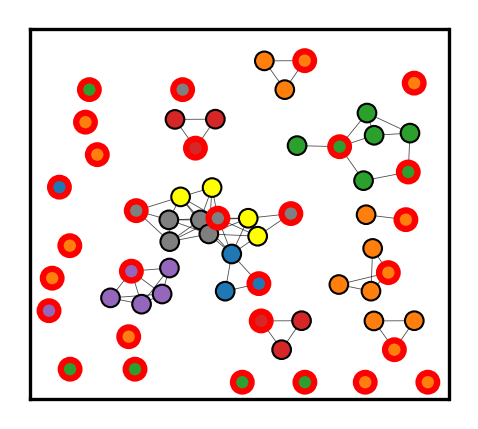

In [58]:
fig = plt.figure(figsize=(1.8, 1.6), dpi=300)
ax = plt.subplot(1, 1, 1)

## Draw all properties
nx.draw_networkx_nodes(new, pos=total_pos, node_size=20, linewidths=0.5,
                       node_color=node_color, edgecolors='black')
## Draw representative properties (red edges)
nx.draw_networkx_nodes(rep, pos=repre_pos, node_size=20, linewidths=1.5,
                       node_color=rep_color, edgecolors='red')
## Draw relation edges
nx.draw_networkx_edges(new, pos=total_pos, width=0.2, alpha=0.7)

## Show the coordinates of the graph
pos_data = [total_pos[k] for k in total_pos.keys()]
print('X:', round(min([n[0] for n in pos_data])), round(max([n[0] for n in pos_data])))
print('Y:', round(min([n[1] for n in pos_data])), round(max([n[1] for n in pos_data])))

plt.show()
plt.clf()
plt.close()

# 2. Prediction relation graphs and ranking predictivities
&emsp; We analyzed the pairwise correlations of error metrics of properties in previous section. Here, we continue to explore the relations of property errors considering the inter-dependency of error metrics for properties, or the multicollinearity. This is done by using [Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) models, which is a widely used tool to handle multicollinearity because of its regularization. Lasso is a technique known for feature selection and feature shrinkage in machine learning.  
  
### 2.1 Prediction relation graphs
&emsp; The strength of prediction relations is measured by the coefficient of input error metric in Lasso. Similar to the coefficients of logistic regression models for explanation in Notebook 02, the Lasso coefficients describe the importance of property errors when they are used to make predictions, which implies the strength of prediction relations. Given the use of Lasso to handle inter-dependency or multicollinearity of input features, constructing prediction relation graphs of properties using Lasso models provides critical insights when assessing the relations for a large group of properties.    

&emsp; In this section, we adopt the following steps (details are in the methods of main text) to obtain the Lasso coefficients and construct the prediction relation graphs of properties:  

 - <u>**Step 1**: pick a property, take its error metric, and use the error metrics of remaining 59 properties to predict it</u>  
   &emsp; Obtain the input data X and output data Y.  
   
 - <u>**Step 2**: fine-tune the hyper-parameter $\alpha$ of Lasso</u>  
   &emsp; Since we choose Lasso, we need to fine-tune its hyper-parameter $\alpha$ before we train models. We simply use all data in this step without bootstrap resampling or other techniques because we don't aim to use the produced models for predictions and are generally not concerned by achieving the higher prediction scores. This process focuses on producing stable coefficients that will not have large variance to different training data. The detailed procedures are described in the Supporting Information.  
   
 - <u>**Step 3**: fit Lasso models and obtain stable coefficients</u>  
   &emsp; To reduce the variance of coefficients in Lasso models due to training data overfitting, we adopt a bootstrap resampling process and train a series of Lasso models with different training data. In this resampling process, we have 20 resampling iterations. We randomly select 2/3 of all data as training data and leave the remaining 1/3 as testing data in each iteration. All Lasso models trained by different resampled datasets use the same selected $\alpha$ from previous step (2). We also collect the $R^{\mathrm{2}}$ score on testing data to evaluate the effectiveness of the trained Lasso model.  
   
 - <u>**Step 4**: take the average of Lasso coefficients</u>  
   &emsp; After 20 resampling steps, we train 20 Lasso models and take the average of their coefficients as the feature importances of input error metrics. We also take the average of $R^{\mathrm{2}}$ scores to evaluate how reliable these coefficients are. The higher the $R^{\mathrm{2}}$ scores are, the more likely these coefficients are to reflect the true importance of these error metrics.  
  
- <u>**Step 5**: iterate step (1) - (4) for all properties</u>  
   &emsp; Iteratively setting error metrics of all properties as predicted targets enables us to construct a full prediction relation graph which describes how important each error metric is when used to predict the others.  

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split

def GridCV(X, Y, estimator, grid):
    """
        Function to search for the best hyper-parameter
        The same function defined in 02 Notebook
    """
    est = deepcopy(estimator) ## base estimator

    ## The cross-validation strategy here is to split into 10 fold
    ## and repeat for 3 times
    cv = RepeatedKFold(n_splits=10, n_repeats=3)
    search = GridSearchCV(estimator, grid, scoring='neg_mean_absolute_error', cv=cv,
                          n_jobs=-1)
    results = search.fit(X, Y)
    return results.best_params_

**Note**: run the first two cells in correlation graph section (after the tutorial part) for pre-processing and obtaining necessary information.

In [10]:
## Pre-processing
mlip = 'full' ## select a type of MLIP

if mlip.lower()=='full':
    df = deepcopy(norm_log_data) ## all MLIPs
else:
    df = norm_log_data.loc[norm_log_data['Models']==mlip]

base_estimator = Lasso(max_iter=10000)
## Prepare the coefficient matrix
coef_matrix = np.zeros((len(properties), len(properties)))
r2_scores = []

**Note**: the order of target properties follows Supplementary Table S13 in Supporting Information, or the first figure in Notebook 01.

In [75]:
resample = 20
## Iterate through all properties
## This is actually step 5
for ip, p in enumerate(properties):
    """
        Step 1: get all data
    """
    ## Here, all X and Y properties are ordered as Supplementary Table S13
    Y_ = [n for n in df[p]]
    X_T = [[n for n in df[m]] for m in properties if m!=p]
    X_ = np.transpose(X_T)
    # print(np.shape(Y_), np.shape(X_))
    xs = [m for m in properties if m!=p]

    """
        Step 2: fine-tune hyperparameter alpha
    """
    ## Search for the best hyperparameter
    grid = {'alpha': np.logspace(-1.5, 1.5, 31)}
    params = GridCV(X_, Y_, base_estimator, grid)
    alpha = params['alpha']
    
    ## To get the averaged coefficients and averaged r2
    coefs = []
    scores = []
    """
        Step 3: bootstrap resample and train Lasso
    """
    for rs in range(resample):
        lasso = Lasso(alpha=alpha, max_iter=10000)
        X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.33)
        lasso.fit(X_train, y_train)
        coefs.append(deepcopy([n for n in lasso.coef_]))
        scores.append(lasso.score(X_test, y_test))
    
    ## obtain the Lasso coefficients
    coefsT = np.transpose(coefs)
    for cfs, x in zip(coefsT, xs):
        ## the input error metrics are ordered as Supplementary Table S13
        ix = properties.index(x)
        """
            Step 4: take the average of coefficients and R2
        """
        ## The 1st index is Y --> target property
        ## The 2nd index is X --> input property
        coef_matrix[ip][ix] = np.mean(cfs)
    coef_matrix[ip][ip] = np.nan
    r2_scores.append(np.mean(scores))

/Users/yunshengliu/miniconda3/envs/intf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [76]:
output = open('data/FigSI/{}_pr.json'.format(mlip), 'w')
json.dump({'Matrix': coef_matrix.tolist(), 'R2': r2_scores}, output)
output.close()

In [11]:
with open('data/FigSI/{}_pr.json'.format(mlip), 'r') as file:
    pr_data = json.load(file)
file.close()
coef_matrix = pr_data['Matrix']
r2_scores = pr_data['R2']

In [12]:
"""
    Prepare the scatter plot of prediction relation matrix.
    Note that the order of properties is critical.
    Make sure that the coefficients are arranged in the correct order
        because it's hard to double check without explicit strings.
"""
pxs_ = []
pys_ = []
pzs_ = []
for ix in range(len(properties)):
    for iy in range(len(properties)):
        pxs_.append(ix)
        pys_.append(iy)
        ## Y (target property) is 1st element
        ## X (input property) is 2nd element
        pzs_.append(coef_matrix[iy][ix])
## Verify coefficients' range
zs = [n for n in pzs_ if not np.isnan(n)]
print(round(min(zs), 2), round(max(zs), 2))

-0.73 0.95


**Note**: It's important that coefficients are comparable and reasonable to construct prediction relation graph. Since all error metrics of properties are normalized, including the target and the input error metrics, the coefficients should empirically be reasonable within (-1.5, 1.5). If there're coefficients too large or too small, it's worthwhile to double check and be cautious.  
  
The figure produced here follows the scheme in *Supplementary Figure S9* and *S10*.

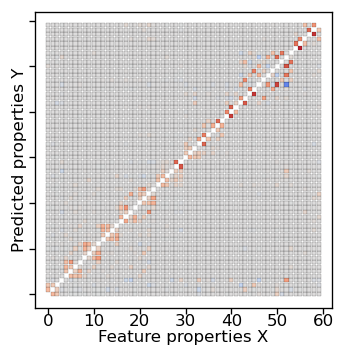

In [15]:
"""
    Increase the dpi to 300 or more to have a better resolution
    and identify the properties following Supplementary Table S13
"""
fig = plt.figure(figsize=(3.2, 3.2), dpi=120)
ax = plt.subplot(1, 1, 1)
points = ax.scatter(pxs_, pys_, c=pzs_, vmin=-1, vmax=1, s=6, marker='s', edgecolors='black', linewidths=0.1,
                    cmap='coolwarm')
# cbar = plt.colorbar(points)
# cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
# cbar.ax.set_yticklabels([])
ax.set_xlabel('Feature properties X', fontsize=10, labelpad=0.5)
ax.set_ylabel('Predicted properties Y', fontsize=10, labelpad=0.5)

## Format figures
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels([], fontsize=10)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60])
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60], fontsize=10)
# plt.savefig('figureSI/{}_pr-matrix.png'.format(mlip), bbox_inches='tight', dpi=300)
plt.show()
plt.clf()
plt.close()

The $R^{\mathrm{2}}$ score figure follows the scheme in *Supplementary Figure S9* and *S10*.

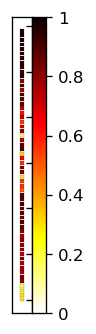

In [16]:
fig = plt.figure(figsize=(0.2, 3.2), dpi=120)
ax = plt.subplot(1, 1, 1)
points = ax.scatter(np.zeros(len(properties)), [n for n in range(len(properties))], c=r2_scores,
                    vmin=0, vmax=1, s=5, marker='s', cmap='hot_r', edgecolors='black', linewidths=0.1)
cbar = plt.colorbar(points, fraction=1, pad=1.05)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
## Figure format
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels([], fontsize=10)
ax.set_xticks([])
ax.set_xticklabels([], fontsize=10)

# plt.savefig('figureSI/{}_r2.png'.format(mlip), bbox_inches='tight', dpi=300)
plt.show()
plt.clf()
plt.close()

### 2.2 Ranking predictivities
&emsp; In a prediction relation graph, the importance of a property (a node in the graph) is reflected by both the number of prediction relations it has with other properties and the strengths of its predicition relations. While the strength of a prediction relation (the coefficient of Lasso) indicates the importance of an error metric when making predictions, the number of prediction relations reflects whether the property is generally useful. Overall, the prediction relation graph is a good reflection of properties' capabilities to make predictions, or the predictivities of properties.  
&emsp; Such predictivities can be ranked by both counting the prediction relations and considering strengths of prediction relations in a graph. Following this, we adopt the approach described in *evaluating prediciton relations with multiple properties* in Supporting Information and use the Page Rank algorithm to rank the error metrics in prediction relation graphs. The produced prediction relation graphs follow the scheme in *Supplementary Figure S9* and *S11*. The ranking results are described in Supplementary Table S12.  
  
**Note**: a key step in ranking properties here is to <u>**reverse the direction**</u> of predicition relations in the graph when applying Page Rank algorithm. This is because the Page Rank algorithm emphasizes **incoming** links, while the concept of predictivity emphasizes **outgoing** links. The more relations a property has **to predict** other properties, the more predictivity it has.

**Note**: choices of thresholds  
&emsp; We have a threshold for prediction relations to screen the relations that are too weak.  
&emsp; We have a threshold for Lasso $R^{\mathrm{2}}$ scores because we want to include only the Lasso models that are reliable, in which case they have high $R^{\mathrm{2}}$ scores.

In [80]:
"""
    Construct a directed graph for Page Rank
    The key is to reverse the direction and apply Page Rank
"""
## threshold of the absolute values of prediction relations
pr_threshold = 0.06
## threshold of Lasso R2
lasso_threshold = 0.6

pr_graph = nx.DiGraph()
pr_graph.add_nodes_from(properties, color=node_color)
for ipx, px in enumerate(properties):
    for ipy, py in enumerate(properties):
        if r2_scores[ipy]<lasso_threshold:
            continue
        if ipx!=ipy:
            coef = coef_matrix[ipy][ipx]
            if abs(coef)>pr_threshold:
                ## Note: reverse the direction
                ## Compared with the presented graph below
                pr_graph.add_edge(py, px, coef=abs(coef))

## Page Rank
ranks = nx.pagerank(pr_graph, weight='coef', max_iter=100)
rank_result = [(n, ranks[n]) for n in ranks.keys()]
rank_result = sorted(rank_result, key=lambda k: k[1], reverse=True)

## Positions of properties on the graph
pos = nx.nx_agraph.graphviz_layout(pr_graph, prog="neato", args="-Gmaxiter=200")

/Users/yunshengliu/miniconda3/envs/intf/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: ['tab is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [81]:
## Output the ranking and coordinate information
output = {'Property': [], 'Rank': [], 'X': [], 'Y': []}
for rank in rank_result:
    output['Property'].append(rank[0])
    output['Rank'].append(rank[1])
    output['X'].append(pos[rank[0]][0])
    output['Y'].append(pos[rank[0]][1])
outdf = pds.DataFrame(output)
outdf.to_csv('data/FigSI/{}_rank.csv'.format(mlip))

In [7]:
## Load the ranking and the position data
with open('data/FigSI/{}_pr.json'.format(mlip), 'r') as file:
    pr_data = json.load(file)
file.close()

coef_m = pr_data['Matrix']
r2_s = pr_data['R2']

rankdf = pds.read_csv('data/FigSI/{}_rank.csv'.format(mlip)).drop(columns=['Unnamed: 0'])
rankdf.head()

,Property,Rank,X,Y
0,super_c12,0.042339,345.65,212.55
1,bulk_entropy,0.036050,173.25,255.96
2,super_c44,0.034396,360.77,259.75
3,super_bulkmodulus,0.034376,350.09,123.56
4,vac_c12,0.033412,262.87,201.88


In [9]:
## Post-process: get the coordinates and colors
total_pos = {}
highr_pos = {}
total_color = []
highr_color = []

for pi, (p, x, y) in enumerate(zip(rankdf['Property'], rankdf['X'], rankdf['Y'])):
    total_pos[p] = (x, y)
    index = properties.index(p)
    total_color.append(node_color[index])
    if pi<10:
        highr_pos[p] = (x, y)
        highr_color.append(node_color[index])

In [10]:
"""
    Construct a directed graph for prediction relations
    This is to reproduce figures of S9 and S11.
"""
pr_threshold = 0.06
lasso_threshold = 0.6
dgraph = nx.DiGraph()
dgraph.add_nodes_from(rankdf['Property'], color=total_color)
for px in rankdf['Property']:
    for py in rankdf['Property']:
        ipx = properties.index(px)
        ipy = properties.index(py)
        if r2_s[ipy]<lasso_threshold:
            continue
        if ipx!=ipy:
            coef = coef_m[ipy][ipx]
            if abs(coef)>pr_threshold:
                dgraph.add_edge(px, py, coef=abs(coef))

In [11]:
high_rank_graph = nx.Graph()
high_rank_graph.add_nodes_from(rankdf['Property'][:10], color=highr_color)

X: 90 641
Y: 18 880


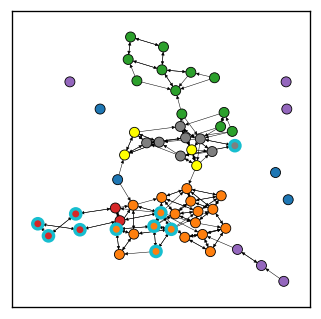

In [12]:
fig = plt.figure(figsize=(3.2, 3.2), dpi=120)
ax = plt.subplot(1, 1, 1)

## Draw all nodes
nx.draw_networkx(dgraph, total_pos, node_color=total_color, node_size=36, edgecolors='black',
                 linewidths=0.5, edge_color='black', arrowsize=4, width=0.3,
                 with_labels=False)
## Draw high-rank nodes
nx.draw_networkx_nodes(high_rank_graph, pos=highr_pos, node_size=38, linewidths=2,
                       node_color=highr_color, edgecolors='tab:cyan')

pos_data = [total_pos[k] for k in total_pos.keys()]
print('X:', round(min([n[0] for n in pos_data])), round(max([n[0] for n in pos_data])))
print('Y:', round(min([n[1] for n in pos_data])), round(max([n[1] for n in pos_data])))

# plt.savefig('figureSI/{}_RankingGraph.png'.format(mlip), bbox_inches='tight', dpi=300)
plt.show()
plt.clf()
plt.close()

**Note**: if you wish to know which node corresponds to which property, `dgraph.nodes` contains strings of properties and can be used to add annotations to the graph figure.